# Implement Board Game with Q learning

Implement the interaction of a reinforecment learning agent with its environment.

1. Create an agent that chooses actions randomly with this environment. 

2. Create an agent that uses Q-learning. Initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. 

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy. 


## The environment: Navigation in a gridworld

<img src="img/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

Use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](img/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
# Game environment
class Board:
    def __init__(self, p_random = 0.2):
        self.num_rows = 5
        self.num_cols = 5
        self.num_cells = self.num_cols * self.num_rows
        
        # Choose starting position of the agent randomly among the first 5 cells
        self.agent_position = np.random.randint(0, 5)
        
        # Choose position of the gold and bomb
        self.bomb_positions = np.array([18])
        self.gold_positions = np.array([23])
        self.terminal_states = np.array([self.bomb_positions, self.gold_positions])
       
        # Specify rewards
        self.rewards = np.zeros(self.num_cells)
        self.rewards[self.bomb_positions] = -10
        self.rewards[self.gold_positions] = 10
        
        # Specify available actions
        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]
        
        self.p_random = p_random
    
    def get_available_actions(self):
        return self.actions
    
    def make_step(self, action): 
        old_position = self.agent_position
        new_position = self.agent_position
        
        # 0.2 probability to move the agent in other directions
        if np.random.rand(1) < self.p_random:
            all_actions = np.array(self.actions)
            available_actions = list(all_actions[all_actions!=action])
            action = available_actions[np.random.randint(0,len(available_actions))]
        
        # Update new_position based on the chosen action and check whether agent hits a wall.
        if action == "UP":
            candidate_position = self.agent_position + self.num_cols
            if candidate_position < self.num_cells:
                new_position = candidate_position
        elif action == "RIGHT":
            candidate_position = self.agent_position + 1
            if candidate_position % self.num_cols > 0:
                new_position = candidate_position
        elif action == "DOWN":
            candidate_position = self.agent_position - self.num_cols
            if candidate_position >= 0:
                new_position = candidate_position
        elif action == "LEFT": 
            candidate_position = self.agent_position - 1
            if candidate_position % self.num_cols < self.num_cols - 1:
                new_position = candidate_position
        else:
            raise ValueError('Action was mis-specified!')
        
        # Update the position of the agent.
        self.agent_position = new_position
        
        # Get reward 
        reward = self.rewards[new_position]
              
        # Deduct 1 from reward if agent moved
        if old_position != new_position:
            reward -= 1
        
        return reward
    
    # reset game when the game ended
    def reset_game(self):
        self.__init__()
        

In [3]:
# Random agent
class Random_Agent():
    def choose_action(self, available_actions):
        number_of_actions = len(available_actions)
        random_index = np.random.randint(0, number_of_actions)
        action = available_actions[random_index]
        return action
    

In [4]:
# Q learning agent
class Q_Agent:
    def __init__(self, alpha = 0.1, greedy = 0.05):
        self.alpha = alpha
        self.greedy = greedy
        self.q = {key: 0 for key in itertools.product(np.arange(25), ["UP", "RIGHT", "DOWN", "LEFT"])}
    
    def choose_action(self, available_actions, current_position):
        if np.random.rand(1) < self.greedy:
            # Choose not greedy action 
            number_of_actions = len(available_actions)
            index = np.random.randint(0, number_of_actions)
            action = available_actions[index]
        else:
            # Choose greedy action according to Q table
            # Get the maximum Q value of the current state
            max_q = np.array([self.q[key] for key in self.q if key[0]==current_position]).max()
            # Create a current dictionary which is a part of Q table to avoid of different state, but same q value
            current_key = [key for key in self.q if key[0]==current_position]
            new_d = {key:self.q[key] for key in current_key}
            # Choose the action, if there are several actions, choose randomly
            choices = [key for key in new_d if new_d[key]==max_q]
            index = np.random.randint(0, len(choices))
            action = choices[index][1]
            
        return action
    
    def Q_learn(self, old_position, new_position, action, reward):
        # Update Q table
        max_value = np.array([self.q[key] for key in self.q if key[0]==new_position]).max()
        self.q[(old_position,action)] = (1-self.alpha)*self.q[(old_position,action)]+self.alpha*(reward+max_value)
        

In [5]:
# Train Q learning agent
def Train_Q(environment, agent, episodes):
    total_reward = 0
    counts = episodes
    while counts > 0:
        while environment.agent_position not in environment.terminal_states:
            old_position = environment.agent_position
            available_actions = environment.get_available_actions()
            chosen_action = agent.choose_action(available_actions,old_position)
            reward = environment.make_step(chosen_action)
            total_reward += reward
            new_position = environment.agent_position
            agent.Q_learn(old_position,new_position,chosen_action,reward)
        env.reset_game()
        counts -= 1
    mean_reward = total_reward / episodes
    return mean_reward

# Random agent play the game
def Play_Random(environment, agent, episodes):
    total_reward = 0
    counts = episodes
    while counts > 0:
        while environment.agent_position not in environment.terminal_states:
            available_actions = environment.get_available_actions()
            chosen_action = agent.choose_action(available_actions)
            reward = environment.make_step(chosen_action)
            total_reward += reward
        env.reset_game()
        counts -= 1
    mean_reward = total_reward / episodes
    return mean_reward


In [6]:
# Train and play the game
env = Board()
Q_agent = Q_Agent()
Random_agent = Random_Agent()
X = np.arange(1,501)
Q_y = np.array(list(map(lambda x: Train_Q(env,Q_agent,x), X)))
Random_y = np.array(list(map(lambda x: Play_Random(env,Random_agent,x), X)))

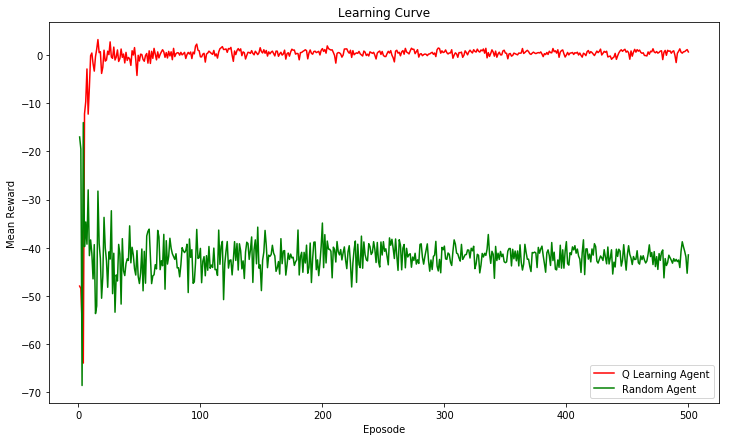

In [7]:
# Plot the curves
plt.figure(figsize=(12,7))
plt.plot(X, Q_y, c='r', label = 'Q Learning Agent')
plt.plot(X, Random_y, c='g', label = 'Random Agent')
plt.xlabel('Eposode')
plt.ylabel('Mean Reward')
plt.title('Learning Curve')
plt.legend(loc = 'best')
plt.show()

In [8]:
Q_agent.q

{(0, 'DOWN'): 0.73448972290380743,
 (0, 'LEFT'): 0.72200766055233689,
 (0, 'RIGHT'): 0.525062539048191,
 (0, 'UP'): 1.3592115532687308,
 (1, 'DOWN'): 1.3139707744149827,
 (1, 'LEFT'): 0.80908646869154366,
 (1, 'RIGHT'): 0.55927765192834866,
 (1, 'UP'): 1.7867012575129579,
 (2, 'DOWN'): 0.86791838601210713,
 (2, 'LEFT'): 0.47472763065741375,
 (2, 'RIGHT'): -0.16041662125244308,
 (2, 'UP'): 1.445610648134422,
 (3, 'DOWN'): -0.044533259780677223,
 (3, 'LEFT'): 0.39837209061340767,
 (3, 'RIGHT'): 0.27007311047835336,
 (3, 'UP'): 0.21139922840369058,
 (4, 'DOWN'): 0.81943707919839703,
 (4, 'LEFT'): 0.039427066856439853,
 (4, 'RIGHT'): 0.89610808554333565,
 (4, 'UP'): 1.1173464004665166,
 (5, 'DOWN'): 0.88235687360315873,
 (5, 'LEFT'): 1.734542757705843,
 (5, 'RIGHT'): 1.56330395893861,
 (5, 'UP'): 2.2649742034864309,
 (6, 'DOWN'): 0.99365531631969883,
 (6, 'LEFT'): 1.2890964886554761,
 (6, 'RIGHT'): 1.899744115333253,
 (6, 'UP'): 2.68045082198537,
 (7, 'DOWN'): 0.93271384006408942,
 (7, 'LE